# PROACT Dataset

In [23]:
import config as cfg
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv(Path.joinpath(cfg.PROACT_DATA_DIR, 'data.csv'), index_col=0)
df = df.loc[(df['TTE_Speech'] > 0) & (df['TTE_Swallowing'] > 0)
            & (df['TTE_Handwriting'] > 0) & (df['TTE_Walking'] > 0)] # min time
df = df.loc[(df['TTE_Speech'] <= 1800) & (df['TTE_Swallowing'] <= 1800)
            & (df['TTE_Handwriting'] <= 1800) & (df['TTE_Walking'] <= 1800)] # 5 years max
event_cols = ['Event_Speech', 'Event_Swallowing', 'Event_Handwriting', 'Event_Walking']

In [24]:
df.columns

Index(['TTE_Speech', 'Event_Speech', 'TTE_Swallowing', 'Event_Swallowing',
       'TTE_Handwriting', 'Event_Handwriting', 'TTE_Walking', 'Event_Walking',
       'SOO', 'Diagnosis_Delta', 'Subject_used_Riluzole', 'El_escorial',
       'FVC_Min', 'FVC_Max', 'FVC_Mean', 'Handgrip_Strength', 'ANKLE_Strength',
       'ELBOW_Strength', 'FIRST_DORSAL_INTEROSSEOUS_OF_THE_HAND_Strength',
       'HIP_FLEXOR_Strength', 'KNEE_Strength', 'SHOULDER_Strength',
       'WRIST_Strength'],
      dtype='object')

In [25]:
for event_col in event_cols:
    obs_arr = np.array(df[event_col])
    n_censored = obs_arr.shape[0] - obs_arr.sum()
    print(f"Number of samples: {len(df)}")
    print(f"Number of censored/uncensored: {n_censored}/{obs_arr.shape[0]-n_censored}")
    print(f"{round(n_censored / obs_arr.shape[0] * 100, 2)}% of records are censored\n")

Number of samples: 5188
Number of censored/uncensored: 2549/2639
49.13% of records are censored

Number of samples: 5188
Number of censored/uncensored: 2893/2295
55.76% of records are censored

Number of samples: 5188
Number of censored/uncensored: 2163/3025
41.69% of records are censored

Number of samples: 5188
Number of censored/uncensored: 1345/3843
25.93% of records are censored



In [26]:
df.columns

Index(['TTE_Speech', 'Event_Speech', 'TTE_Swallowing', 'Event_Swallowing',
       'TTE_Handwriting', 'Event_Handwriting', 'TTE_Walking', 'Event_Walking',
       'SOO', 'Diagnosis_Delta', 'Subject_used_Riluzole', 'El_escorial',
       'FVC_Min', 'FVC_Max', 'FVC_Mean', 'Handgrip_Strength', 'ANKLE_Strength',
       'ELBOW_Strength', 'FIRST_DORSAL_INTEROSSEOUS_OF_THE_HAND_Strength',
       'HIP_FLEXOR_Strength', 'KNEE_Strength', 'SHOULDER_Strength',
       'WRIST_Strength'],
      dtype='object')

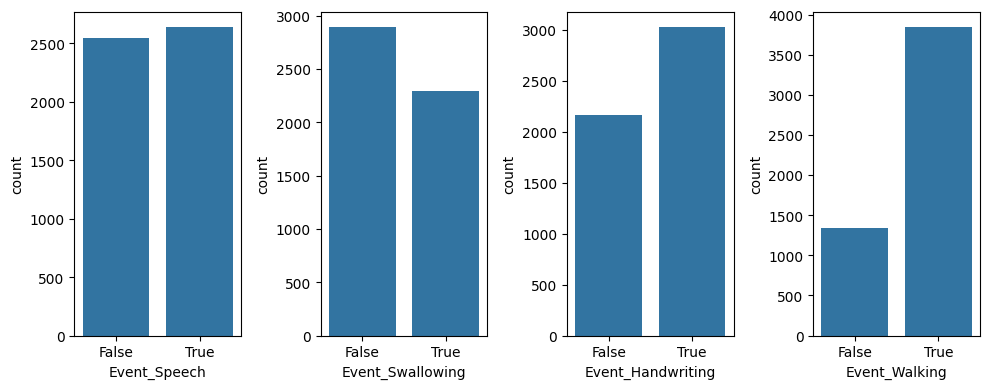

In [27]:
fig, axs = plt.subplots(ncols=len(event_cols), figsize=(10,4))
for i, col in enumerate(event_cols):
    sns.countplot(x=col, data=df, ax=axs[i])
plt.tight_layout()
plt.show()

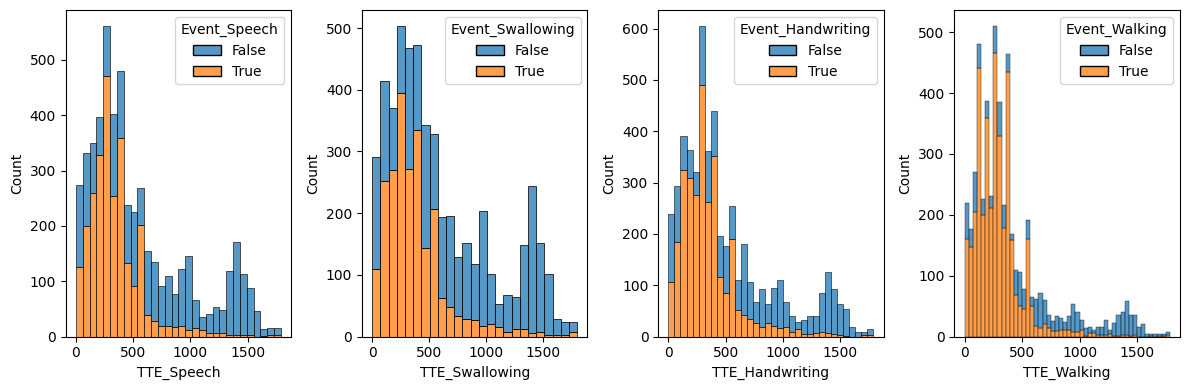

In [30]:
fig, axs = plt.subplots(ncols=len(event_cols), figsize=(12,4))
event_names = ['Speech', 'Swallowing', 'Handwriting', 'Walking']
for i, col in enumerate(event_names):
    event = df[[f'TTE_{col}', f'Event_{col}']]
    sns.histplot(x=f'TTE_{col}', data=event, hue=f'Event_{col}', multiple="stack", bins="auto", ax=axs[i])
plt.tight_layout()
plt.show()